# Capacity allocation

## 0. Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from benchmarks.generator import get_revenue_behaviour, get_revenue_behaviour_deprecated
from benchmarks.robin_railway import RevenueMaximization
from benchmarks.utils import sns_box_plot, sns_line_plot, int_input, get_schedule_from_supply, infer_line_stations, get_services_by_tsp_df, plot_marey_chart
from src.entities import GSA, Solution

from robin.scraping.entities import SupplySaver
from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Service, Supply

from pathlib import Path
from typing import Any, List, Mapping, Tuple, Union
import shutil

In [2]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/generator/supply_dummy.yml')
supply_save_path = '../configs/mealpy/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

#if Path(figures).exists():
#    shutil.rmtree(figures)
#Path(figures).mkdir(parents=True)

In [3]:
seed = 21

if generator_config_path:
    n_services = int_input("Number of services to generate: ")
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    _ = generator.generate(file_name=generator_save_path,
                           path_config=generator_config_path,
                           n_services=n_services,
                           seed=seed)
    print(f'Number of service requests generated: {len(_)}')

Number of service requests generated: 25


In [4]:
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)

print(tsp_df)

       Number of Services
RU2                     4
RU3                    10
RU1                     6
RU4                     5
Total                  25


In [5]:
print("Services: ", len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behaviour = get_revenue_behaviour_deprecated(supply)
lines = supply.lines
line = infer_line_stations(lines)

Services:  25


/Users/david/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


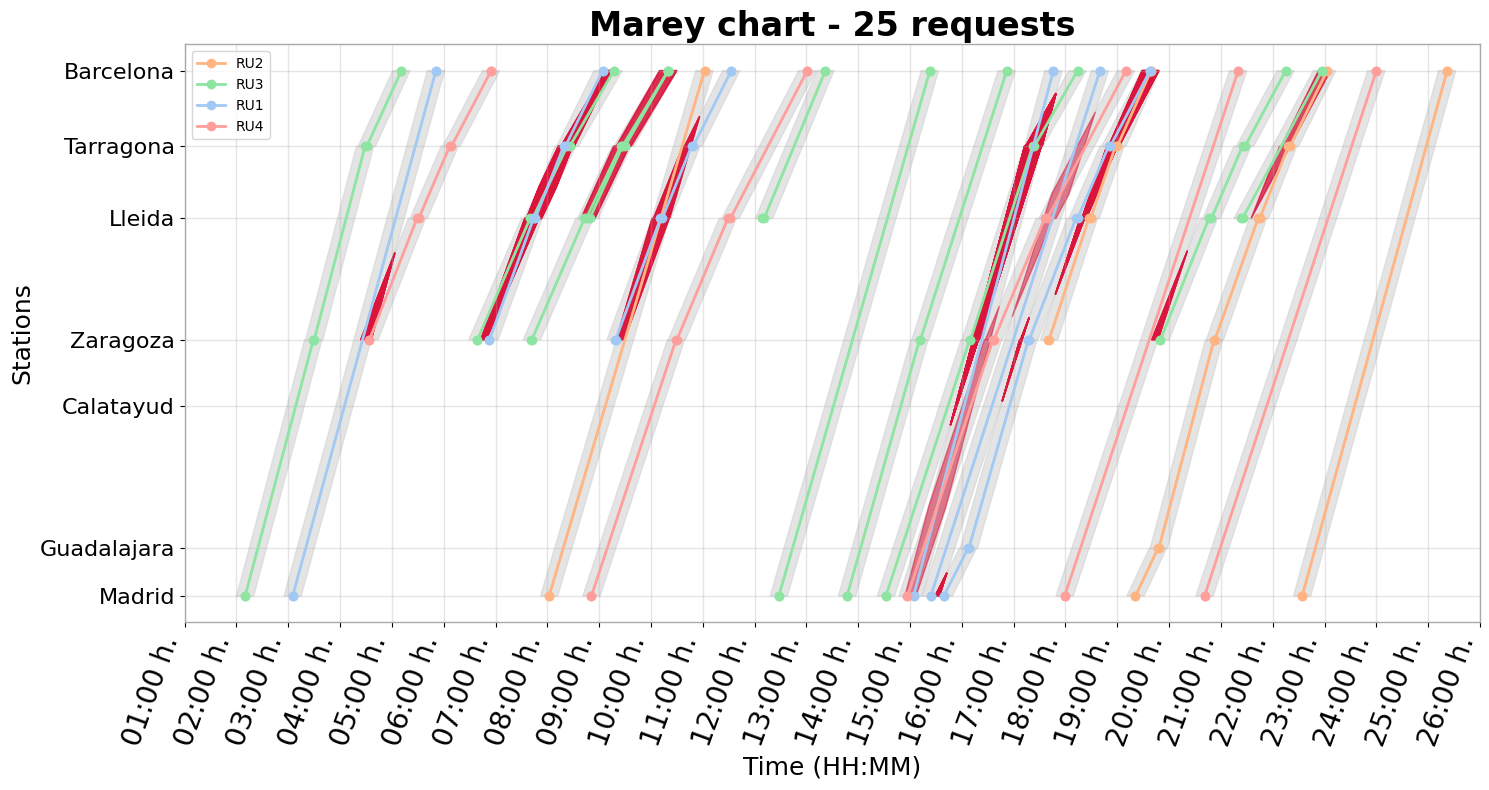

In [6]:
plot_marey_chart(requested_supply=supply,
                 colors_by_tsp=True, 
                 main_title="Marey chart - 25 requests",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/mealpy/marey_chart_requests_25.pdf'))

## 1. Mealpy

In [7]:
from src.timetabling_problem import MPTT

mptt = MPTT(requested_schedule=requested_schedule,
            revenue_behaviour=revenue_behaviour,
            line=line,
            safe_headway=10)

In [8]:
from mealpy.evolutionary_based import DE, ES, GA
from mealpy.swarm_based import ABC, ACOR, GWO, PSO, WOA
from mealpy.physics_based import SA

mp_algos = {"Genetic Algorithm": GA.BaseGA}

In [9]:
from mealpy import IntegerVar

runs = 5
epochs = 100
pop_size = 50

seed_initializer = 29

# 0. Problem formulation
lb, ub = zip(*mptt.boundaries.real)

problem = {"obj_func": mptt.objective_function,
           "bounds": IntegerVar(lb=lb,
                              ub=ub),
           "minmax": "max",
           "save_population": True}

# 1. Iter algorithms
df_history = pd.DataFrame()
df_population = pd.DataFrame()

for algo_name, algo in mp_algos.items():
    
    # Re-initialize seed
    np.random.seed(seed_initializer)
    
    print(f"Running {algo_name}")
    for r in range(1, runs+1):
        print("\tRun: ", r)
        
        run_seed = np.random.randint(0, 1000)
        
        # Run algorithm
        if algo_name == "Simulated Annealing":
            optimizer = algo(epoch=epochs*pop_size)
            optimizer.solve(problem, seed=run_seed)
        else:
            optimizer = algo(epoch=epochs, pop_size=pop_size)
            optimizer.solve(problem, seed=run_seed)
            
        # Build run history dataframe
        columns = ['Algo', 'Iteration', 'Fitness', 'ExecutionTime', 'Discrete', 'Real', 
                   'Diversity', 'Exploitation', 'Exploration']
        run_history = pd.DataFrame(columns=columns)
        
        # Save optimizer history to dataframe
        for i, data in enumerate(optimizer.history.list_global_best):
            mptt.update_schedule(data.solution)
            run_history.loc[i] = [algo_name,
                                  i, 
                                  data.target.fitness,
                                  optimizer.history.list_epoch_time[i],
                                  mptt.get_heuristic_schedule_new(),
                                  data.solution,
                                  optimizer.history.list_diversity[i],
                                  optimizer.history.list_exploitation[i],
                                  optimizer.history.list_exploration[i]]
    
        run_history.insert(0, "Run", r)
        df_history = pd.concat([df_history, run_history], axis=0)
        
        # Population dataframe
        if algo_name == "Simulated Annealing":
            continue
        
        population_colums = [f'real_{i}' for i in range(pop_size)] + [f'discrete_{i}' for i in range(pop_size)]
        population_colums.insert(0, 'Iteration')
        run_population = pd.DataFrame(columns=population_colums)
        
        for i, pop_epoch in enumerate(optimizer.history.list_population):
            population_row = [i]
            real = []
            discrete = [] 
            for individual in pop_epoch:
                mptt.update_schedule(individual.solution)
                real.append(individual.solution)
                discrete.append(mptt.get_heuristic_schedule_new())
            
            population_row = [i, *real, *discrete]
            run_population.loc[len(run_population)] = population_row
        
        run_population.insert(0, "Run", r)
        run_population.insert(1, "Algo", algo_name)
        df_population = pd.concat([df_population, run_population], axis=0)    

2025/02/10 10:31:34 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: Solving single objective optimization problem.


Running Genetic Algorithm
	Run:  1


2025/02/10 10:31:34 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2430.3882750726634, Global best: 2430.3882750726634, Runtime: 0.25161 seconds
2025/02/10 10:31:35 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2420.6275311851105, Global best: 2430.3882750726634, Runtime: 0.24573 seconds
2025/02/10 10:31:35 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2471.981136866205, Global best: 2471.981136866205, Runtime: 0.24106 seconds
2025/02/10 10:31:35 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 2624.6549447973844, Global best: 2624.6549447973844, Runtime: 0.24597 seconds
2025/02/10 10:31:35 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 2683.500815980847, Global best: 2683.500815980847, Runtime: 0.24264 seconds
2025/02/10 10:31:36 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Ep

	Run:  2


2025/02/10 10:32:19 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2464.6419647642683, Global best: 2464.6419647642683, Runtime: 0.23546 seconds
2025/02/10 10:32:20 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2670.7803516791164, Global best: 2670.7803516791164, Runtime: 0.23665 seconds
2025/02/10 10:32:20 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2703.4014022267997, Global best: 2703.4014022267997, Runtime: 0.24269 seconds
2025/02/10 10:32:20 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 2717.00012423377, Global best: 2717.00012423377, Runtime: 0.23638 seconds
2025/02/10 10:32:20 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 2705.9848508576406, Global best: 2717.00012423377, Runtime: 0.24095 seconds
2025/02/10 10:32:21 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoc

	Run:  3


2025/02/10 10:33:05 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2344.5618433870864, Global best: 2344.5618433870864, Runtime: 0.24553 seconds
2025/02/10 10:33:06 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2433.137335578396, Global best: 2433.137335578396, Runtime: 0.24052 seconds
2025/02/10 10:33:06 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2576.4765773975623, Global best: 2576.4765773975623, Runtime: 0.24137 seconds
2025/02/10 10:33:06 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 2624.0199119182803, Global best: 2624.0199119182803, Runtime: 0.24152 seconds
2025/02/10 10:33:06 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 2655.466633334505, Global best: 2655.466633334505, Runtime: 0.24140 seconds
2025/02/10 10:33:07 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Ep

	Run:  4


2025/02/10 10:33:51 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2270.206396446179, Global best: 2281.792862942122, Runtime: 0.24730 seconds
2025/02/10 10:33:51 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2545.2010624465033, Global best: 2545.2010624465033, Runtime: 0.24191 seconds
2025/02/10 10:33:51 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2785.3128481312124, Global best: 2785.3128481312124, Runtime: 0.24710 seconds
2025/02/10 10:33:51 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 2823.6254864929856, Global best: 2823.6254864929856, Runtime: 0.24443 seconds
2025/02/10 10:33:52 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 2830.170736257166, Global best: 2830.170736257166, Runtime: 0.24493 seconds
2025/02/10 10:33:52 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Ep

	Run:  5


2025/02/10 10:34:38 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2471.771429180884, Global best: 2471.771429180884, Runtime: 0.26458 seconds
2025/02/10 10:34:38 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2502.204660360824, Global best: 2502.204660360824, Runtime: 0.28392 seconds
2025/02/10 10:34:39 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2669.7338511232497, Global best: 2669.7338511232497, Runtime: 0.26499 seconds
2025/02/10 10:34:39 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 2706.176567522657, Global best: 2706.176567522657, Runtime: 0.26342 seconds
2025/02/10 10:34:39 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 2719.491222409948, Global best: 2719.491222409948, Runtime: 0.25734 seconds
2025/02/10 10:34:39 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch:

## 2. Results analysis

In [10]:
reports_path = Path('../reports/mealpy/')

In [11]:
df_history.to_csv(reports_path / 'df_history_equity.csv', sep=";", index=False)

In [12]:
df_population.to_csv(reports_path / 'df_population_equity.csv', sep=";", index=False)

In [13]:
df_history = pd.read_csv(reports_path / 'df_history_equity.csv', sep=";")
df_population = pd.read_csv(reports_path / 'df_population_equity.csv', sep=";")

In [14]:
df_history

,Run,Algo,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration
0,1,Genetic Algorithm,0,2430.388275,0.251615,[ True False True True True False True Tr...,[1059. 1113. 1147. 866. 979. 1044. 901. 82...,3.122105,0.000000,100.000000
1,1,Genetic Algorithm,1,2430.388275,0.245726,[ True False True True True False True Tr...,[1059. 1113. 1147. 866. 979. 1044. 901. 82...,2.743158,12.137559,87.862441
2,1,Genetic Algorithm,2,2471.981137,0.241058,[ True False True True True False True Tr...,[1059. 1109. 1143. 878. 970. 1047. 894. 82...,2.634737,15.610249,84.389751
3,1,Genetic Algorithm,3,2624.654945,0.245973,[ True False True True True True True Tr...,[1059. 1109. 1143. 874. 970. 1051. 901. 82...,2.551579,18.273769,81.726231
4,1,Genetic Algorithm,4,2683.500816,0.242645,[ True True False True True True True Tr...,[1059. 1111. 1146. 871. 970. 1051. 910. 82...,2.485263,20.397842,79.602158
...,...,...,...,...,...,...,...,...,...,...
495,5,Genetic Algorithm,95,3350.957976,0.265770,[ True True False True True True True Tr...,[1061. 1109. 1140. 872. 970. 1044. 908. 82...,0.604211,81.192661,18.807339
496,5,Genetic Algorithm,96,3351.879849,0.327003,[ True True False True True True True Tr...,[1061. 1109. 1140. 872. 970. 1044. 908. 82...,0.593333,81.531236,18.468764
497,5,Genetic Algorithm,97,3351.879849,0.284377,[ True True False True True True True Tr...,[1061. 1109. 1140. 872. 970. 1044. 908. 82...,0.635789,80.209699,19.790301
498,5,Genetic Algorithm,98,3351.879854,0.325855,[ True True False True True True True Tr...,[1061. 1109. 1140. 872. 970. 1044. 908. 82...,0.618246,80.755789,19.244211


In [18]:
df_population

,Run,Algo,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,discrete_40,discrete_41,discrete_42,discrete_43,discrete_44,discrete_45,discrete_46,discrete_47,discrete_48,discrete_49
0,1,Genetic Algorithm,0,[1054. 1108. 1143. 882. 973. 1051. 909. 82...,[1053. 1102. 1146. 864. 970. 1053. 897. 82...,[1062. 1108. 1141. 873. 975. 1051. 897. 82...,[1053. 1109. 1146. 882. 973. 1054. 896. 82...,[1053. 1109. 1149. 876. 966. 1052. 903. 82...,[1053. 1104. 1142. 882. 971. 1054. 896. 83...,[1061. 1106. 1148. 875. 970. 1053. 905. 83...,...,[False False True True True False True Tr...,[False False True True True True True Tr...,[ True False True True True True True Fal...,[ True False True True True True True Fal...,[ True False True True True False True Fal...,[ True False True True True True True Fal...,[False False True True True False True Tr...,[ True False True True True True True Fal...,[ True False True True True True True Fal...,[ True False True True True True True Fal...
1,1,Genetic Algorithm,1,[1071. 1107. 1141. 864. 968. 1051. 903. 82...,[1053. 1107. 1149. 864. 973. 1051. 897. 82...,[1053. 1101. 1149. 862. 971. 1053. 903. 82...,[1053. 1107. 1142. 864. 968. 1051. 898. 83...,[1053. 1104. 1142. 882. 971. 1054. 896. 83...,[1051. 1103. 1143. 869. 970. 1053. 902. 82...,[1066. 1108. 1146. 872. 972. 1051. 909. 83...,...,[False False True True True False True Tr...,[False False True True True True True Tr...,[ True False True True True True True Fal...,[ True False True True True False True Fal...,[False False True True True False True Fal...,[ True False True True True False True Fal...,[ True False True True True True True Fal...,[False False True True True True True Tr...,[ True False True True True False True Fal...,[ True False True True True True True Fal...
2,1,Genetic Algorithm,2,[1053. 1107. 1149. 864. 973. 1051. 903. 82...,[1071. 1108. 1141. 882. 968. 1051. 903. 82...,[1053. 1102. 1142. 862. 973. 1053. 905. 83...,[1062. 1101. 1146. 865. 971. 1052. 898. 82...,[1061. 1108. 1146. 873. 974. 1051. 897. 82...,[1053. 1101. 1146. 865. 973. 1052. 897. 82...,[1062. 1107. 1147. 872. 973. 1053. 894. 82...,...,[ True False True True True False True Fal...,[False False True True True False True Fal...,[ True False True True True True True Fal...,[ True False True True True False True Tr...,[ True False True True True True True Fal...,[ True False True True True False True Fal...,[False False True True True False True Fal...,[ True False True True True True True Fal...,[ True False True True True True True Fal...,[ True False True True True True True Tr...
3,1,Genetic Algorithm,3,[1053. 1102. 1141. 862. 971. 1053. 898. 82...,[1062. 1107. 1146. 873. 969. 1053. 898. 82...,[1062. 1102. 1142. 862. 971. 1053. 898. 83...,[1054. 1107. 1142. 882. 969. 1051. 905. 81...,[1053. 1107. 1149. 873. 973. 1051. 903. 82...,[1053. 1107. 1141. 864. 969. 1053. 898. 82...,[1053. 1102. 1142. 862. 971. 1052. 898. 83...,...,[False False True True True True True Tr...,[ True False True True True False True Fal...,[ True False True True True False True Fal...,[ True False True True True True True Tr...,[ True False True True True True True Fal...,[ True False True True True False True Fal...,[ True False True True True False True Tr...,[ True False True True True True True Fal...,[ True False True True True True True Fal...,[ True False True True True True True Fal...
4,1,Genetic Algorithm,4,[1053. 1107. 1146. 862. 973. 1051. 909. 82...,[1053. 1101. 1146. 882. 971. 1051. 898. 82...,[1053. 1101. 1141. 864. 969. 1053. 897. 82...,[1053. 1107. 1146. 864. 971. 1051. 898. 82...,[1053. 1101. 1141. 882. 971. 1051. 909. 82...,[1053. 1107. 1146. 873. 969. 1053. 898. 82...,[1062. 1102. 1142. 862. 969. 1053. 898. 82...,...,[ True False True True True True True Fal...,[ True False True True True True True Fal...,[ True False True True True True True Tr...,[ True False True True True True True Tr...,[False False True True True False True Tr...,[ True False True True True 

In [15]:
columns_to_transform = df_history.filter(like="Real").columns

df_history[columns_to_transform] = df_history[columns_to_transform].apply(
    lambda col: col.map(lambda x: np.array(list(map(float, x[1:-1].split())), dtype=np.int32))
)

df_history.head()

,Run,Algo,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration
0,1,Genetic Algorithm,0,2430.388275,0.251615,[ True False True True True False True Tr...,"[1059, 1113, 1147, 866, 979, 1044, 901, 827, 9...",3.122105,0.000000,100.000000
1,1,Genetic Algorithm,1,2430.388275,0.245726,[ True False True True True False True Tr...,"[1059, 1113, 1147, 866, 979, 1044, 901, 827, 9...",2.743158,12.137559,87.862441
2,1,Genetic Algorithm,2,2471.981137,0.241058,[ True False True True True False True Tr...,"[1059, 1109, 1143, 878, 970, 1047, 894, 827, 9...",2.634737,15.610249,84.389751
3,1,Genetic Algorithm,3,2624.654945,0.245973,[ True False True True True True True Tr...,"[1059, 1109, 1143, 874, 970, 1051, 901, 827, 9...",2.551579,18.273769,81.726231
4,1,Genetic Algorithm,4,2683.500816,0.242645,[ True True False True True True True Tr...,"[1059, 1111, 1146, 871, 970, 1051, 910, 828, 9...",2.485263,20.397842,79.602158


In [16]:
columns_to_transform = df_history.filter(like="Discrete").columns

df_history[columns_to_transform] = df_history[columns_to_transform].apply(
    lambda col: col.map(lambda x: np.array(list(map(lambda s: True if s == "True" else False, x[1:-1].split())), dtype=bool))
)

df_history.head()

,Run,Algo,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration
0,1,Genetic Algorithm,0,2430.388275,0.251615,"[True, False, True, True, True, False, True, T...","[1059, 1113, 1147, 866, 979, 1044, 901, 827, 9...",3.122105,0.000000,100.000000
1,1,Genetic Algorithm,1,2430.388275,0.245726,"[True, False, True, True, True, False, True, T...","[1059, 1113, 1147, 866, 979, 1044, 901, 827, 9...",2.743158,12.137559,87.862441
2,1,Genetic Algorithm,2,2471.981137,0.241058,"[True, False, True, True, True, False, True, T...","[1059, 1109, 1143, 878, 970, 1047, 894, 827, 9...",2.634737,15.610249,84.389751
3,1,Genetic Algorithm,3,2624.654945,0.245973,"[True, False, True, True, True, True, True, Tr...","[1059, 1109, 1143, 874, 970, 1051, 901, 827, 9...",2.551579,18.273769,81.726231
4,1,Genetic Algorithm,4,2683.500816,0.242645,"[True, True, False, True, True, True, True, Tr...","[1059, 1111, 1146, 871, 970, 1051, 910, 828, 9...",2.485263,20.397842,79.602158


In [17]:
columns_to_transform = df_population.filter(like="real_").columns

df_population[columns_to_transform] = df_population[columns_to_transform].apply(
    lambda col: col.map(lambda x: list(map(float, x[1:-1].split())))
)

df_population.head()

,Run,Algo,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,discrete_40,discrete_41,discrete_42,discrete_43,discrete_44,discrete_45,discrete_46,discrete_47,discrete_48,discrete_49
0,1,Genetic Algorithm,0,"[1055.0, 1109.0, 1141.0, 864.0, 970.0, 1045.0,...","[1069.0, 1109.0, 1143.0, 865.0, 973.0, 1045.0,...","[1061.0, 1114.0, 1143.0, 872.0, 970.0, 1051.0,...","[1059.0, 1109.0, 1143.0, 879.0, 979.0, 1049.0,...","[1053.0, 1109.0, 1148.0, 865.0, 972.0, 1051.0,...","[1059.0, 1114.0, 1143.0, 878.0, 979.0, 1045.0,...","[1053.0, 1109.0, 1141.0, 865.0, 973.0, 1045.0,...",...,[ True False True True True True True Tr...,[ True False True True True True True Tr...,[ True True False True True True True Tr...,[False False True True True True True Tr...,[ True True False True True True True Tr...,[ True False True True True False True Tr...,[ True True False True True False True Tr...,[ True True False True True True True Tr...,[ True False True True True False True Tr...,[ True False False True True False True Tr...
1,1,Genetic Algorithm,1,"[1067.0, 1114.0, 1142.0, 880.0, 975.0, 1050.0,...","[1059.0, 1111.0, 1143.0, 878.0, 973.0, 1047.0,...","[1064.0, 1116.0, 1143.0, 871.0, 978.0, 1049.0,...","[1059.0, 1111.0, 1145.0, 878.0, 974.0, 1047.0,...","[1055.0, 1114.0, 1143.0, 865.0, 979.0, 1045.0,...","[1057.0, 1111.0, 1143.0, 872.0, 970.0, 1047.0,...","[1055.0, 1109.0, 1143.0, 865.0, 979.0, 1045.0,...",...,[ True True False True True True True Tr...,[ True True False True True True True Tr...,[ True True False True True True True Tr...,[ True False True True True True True Tr...,[ True True False True True False True Tr...,[ True False True True True True True Tr...,[ True False True True True True True Tr...,[ True True False True True True True Tr...,[ True False True True True True True Tr...,[ True True False True True True True Tr...
2,1,Genetic Algorithm,2,"[1059.0, 1111.0, 1143.0, 878.0, 970.0, 1045.0,...","[1059.0, 1109.0, 1145.0, 864.0, 974.0, 1047.0,...","[1059.0, 1113.0, 1146.0, 881.0, 970.0, 1046.0,...","[1059.0, 1109.0, 1141.0, 871.0, 977.0, 1051.0,...","[1057.0, 1111.0, 1147.0, 864.0, 970.0, 1046.0,...","[1059.0, 1109.0, 1146.0, 874.0, 973.0, 1051.0,...","[1059.0, 1109.0, 1141.0, 864.0, 970.0, 1046.0,...",...,[ True False True True True False True Tr...,[ True True False True True False True Tr...,[ True False True True True False True Tr...,[ True False True True True False True Tr...,[ True True False True True True True Tr...,[ True True False True True True True Tr...,[ True False True True True False True Tr...,[ True True False True True False True Tr...,[ True False True True True True True Tr...,[ True True False True True False True Tr...
3,1,Genetic Algorithm,3,"[1059.0, 1111.0, 1143.0, 864.0, 970.0, 1051.0,...","[1059.0, 1109.0, 1146.0, 871.0, 970.0, 1045.0,...","[1059.0, 1113.0, 1146.0, 881.0, 977.0, 1046.0,...","[1055.0, 1109.0, 1143.0, 865.0, 979.0, 1048.0,...","[1059.0, 1109.0, 1143.0, 874.0, 970.0, 1051.0,...","[1059.0, 1109.0, 1147.0, 871.0, 970.0, 1051.0,...","[1052.0, 1111.0, 1143.0, 864.0, 973.0, 1045.0,...",...,[ True True False True True True True Tr...,[ True True False True True True True Tr...,[ True True False True True False True Tr...,[ True True False True True False True Tr...,[ True True False True True True True Tr...,[ True True False True True False True Tr...,[ True False True True True True True Tr...,[ True True False True True True True Tr...,[ True True False True True False True Tr...,[ True True False True True False True Tr...
4,1,Genetic Algorithm,4,"[1059.0, 1109.0, 1146.0, 871.0, 970.0, 1047.0,...","[1059.0, 1111.0, 1143.0, 864.0, 977.0, 1051.0,...","[1052.0, 1113.0, 1146.0, 866.0, 977.0, 1044.0,...","[1059.0, 1111.0, 1146.0, 871.0, 970.0, 1051.0,...","[1059.0, 1109.0, 1143.0, 874.0, 970.0, 1051.0,...","[1059.0, 1109.0, 1147.0, 874.0, 970.0, 1051.0,...","[1059.0, 1113.0, 1146.0, 881.0, 977.0, 1046.0,...",...,[ True False True True True True True Tr...,[ True True False True Tr

In [18]:
from src.timetabling_problem import MPTT

# Define new revenue maximization object for results analysis
mptt = MPTT(requested_schedule=requested_schedule,
            revenue_behaviour=revenue_behaviour,
            line=line,
            safe_headway=10)

top_3_algos = ("Genetic Algorithm",)

# Create dataframe with fitness values for each individual of the population
df_pop = df_population[df_population['Algo'].isin(top_3_algos)]

set_filtered_algos = set(df_pop["Algo"])
print(f"Filtered algos: {set_filtered_algos}")

df_pop = df_pop.replace(r'\n', ' ', regex=True)

# Drop unnecessary columns
df_pop.drop(columns=[col for col in df_pop.columns if 'discrete' in col], inplace=True)

# Function to compute fitness
def fitness_from_real(x: np.array) -> float:
    return mptt.objective_function(x)

# Iterate through the dataframe and apply the function with progress feedback
real_columns = df_pop.columns[df_pop.columns.str.contains('real_')]
previous_run, previous_algo = None, None

for index, row in df_pop.iterrows():
    current_run = row['Run']
    current_algo = row['Algo']

    # Print message if there's a change in 'Run' or 'Algo'
    if current_run != previous_run or current_algo != previous_algo:
        print(f"Processing new combination: Run = {current_run}, Algo = {current_algo}")
        previous_run, previous_algo = current_run, current_algo

    # Apply the fitness function to the real columns
    df_pop.loc[index, real_columns] = row[real_columns].map(fitness_from_real)

print("Processing completed.")
df_pop

Filtered algos: {'Genetic Algorithm'}
Processing new combination: Run = 1, Algo = Genetic Algorithm
Processing new combination: Run = 2, Algo = Genetic Algorithm
Processing new combination: Run = 3, Algo = Genetic Algorithm
Processing new combination: Run = 4, Algo = Genetic Algorithm
Processing new combination: Run = 5, Algo = Genetic Algorithm
Processing completed.


,Run,Algo,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,real_40,real_41,real_42,real_43,real_44,real_45,real_46,real_47,real_48,real_49
0,1,Genetic Algorithm,0,2224.035153,1495.873034,1466.105014,1969.271128,2096.267688,1537.460451,1963.381029,...,1572.027308,1870.535306,1519.438729,1608.773587,2105.817255,1569.194794,1565.729252,2140.441239,1258.519199,1394.595449
1,1,Genetic Algorithm,1,1558.512006,1986.093186,2125.518621,2004.889798,2022.311768,1942.460115,2208.190331,...,1935.238579,1775.345075,2048.260768,1803.607021,2169.869705,1617.881139,2225.91196,1654.167567,1894.182983,1761.972315
2,1,Genetic Algorithm,2,2194.909392,1942.148192,1974.890437,1979.002858,2061.900875,2319.529431,1999.761423,...,1942.460115,2089.175412,2168.631556,2206.021169,2133.015038,1761.972315,2471.981137,1923.348088,2074.026149,1900.409429
3,1,Genetic Algorithm,3,2299.442243,2240.98935,2420.627531,2208.190331,2624.654945,2106.323423,1923.348088,...,2388.255735,2187.640599,2079.80621,1942.148192,1944.334065,2323.126579,2544.086961,2521.765108,1923.348088,2219.534844
4,1,Genetic Algorithm,4,2624.576284,2050.237218,2079.80621,2683.500816,2459.144279,2341.417768,2560.569582,...,1851.317191,2109.993281,2356.891362,2452.672219,2281.579102,2335.687632,2275.995517,2331.658013,2257.810001,2435.973934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,5,Genetic Algorithm,95,3350.957971,3350.957976,3350.957971,3145.614437,3153.372527,3153.372527,3145.614437,...,3340.556308,3337.164359,3350.957976,3350.957971,3323.794103,3338.934196,3325.712912,3350.957971,3350.957971,3350.957971
496,5,Genetic Algorithm,96,3145.614437,3153.372527,3145.614437,3145.614437,3350.957971,3145.614437,3350.957971,...,3325.712912,3153.372527,3350.957971,3350.957971,3153.372527,3335.209971,3339.246888,3153.372527,3336.881655,3330.77542
497,5,Genetic Algorithm,97,3350.957971,3325.704727,3145.614437,3350.957976,3350.957971,3350.957976,3335.209971,...,3153.372527,3350.957971,3351.879849,3336.946743,3145.614437,3350.957971,3333.057861,3350.957976,3145.614437,3145.614437
498,5,Genetic Algorithm,98,3350.957976,3350.957976,3342.587068,3350.957971,3333.05245,3350.957976,3167.784422,...,3350.957976,3350.957976,3350.957976,3350.957971,3336.868425,3145.614437,3350.957976,3330.874931,3145.614437,3350.957976


In [19]:
# Save df_pop
df_pop.to_csv(reports_path / 'df_pop_equity.csv', sep=";", index=False)

In [20]:
# Prepare dataframe for boxplot
rows = []
for row in df_pop.iterrows():
    run = row[1]['Run']
    iteration = row[1]['Iteration']
    algo = row[1]['Algo']
    
    for individual in [ind_name for ind_name in row[1].index if 'real_' in ind_name]:
        fitness = row[1][individual]
        rows.append({'Run': run, 'Iteration': iteration, 'Fitness': fitness, 'Algorithm': algo, 'Individual': f'ID_{individual}'})
        
df_boxplot = pd.DataFrame.from_dict(rows, orient='columns')
df_boxplot

,Run,Iteration,Fitness,Algorithm,Individual
0,1,0,2224.035153,Genetic Algorithm,ID_real_0
1,1,0,1495.873034,Genetic Algorithm,ID_real_1
2,1,0,1466.105014,Genetic Algorithm,ID_real_2
3,1,0,1969.271128,Genetic Algorithm,ID_real_3
4,1,0,2096.267688,Genetic Algorithm,ID_real_4
...,...,...,...,...,...
24995,5,99,3335.318169,Genetic Algorithm,ID_real_45
24996,5,99,3351.879849,Genetic Algorithm,ID_real_46
24997,5,99,3153.372527,Genetic Algorithm,ID_real_47
24998,5,99,3148.125853,Genetic Algorithm,ID_real_48


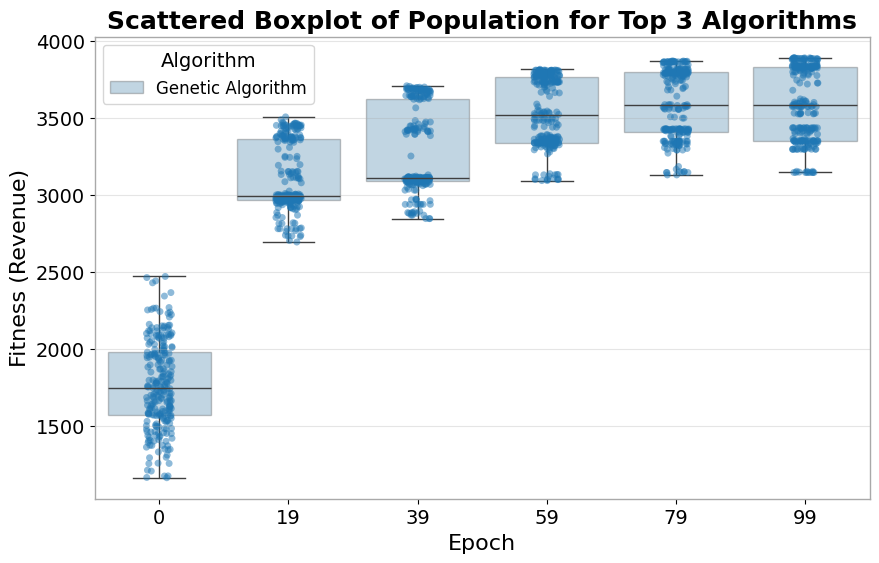

In [21]:
# Filter df, only rows with 'Iteration' values included in [0, .., 49]
df_boxplot_filtered = df_boxplot[df_boxplot['Iteration'].isin([0, 19, 39, 59, 79, 99])]

sns_box_plot(df=df_boxplot_filtered,
             x_data='Iteration',
             y_data='Fitness',
             hue='Algorithm',
             title="Scattered Boxplot of Population for Top 3 Algorithms",
             x_label="Epoch",
             y_label="Fitness (Revenue)",
             save_path=Path('../reports/mealpy/scattered_boxplot_top_3_25.pdf'))

In [33]:
# Table with results by run

sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)

service_tsps = {service.id: service.tsp.name for service in supply.services}
columns = ['Algorithm', 'Run', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)']
columns += set(service_tsps.values())
columns += [f"{tsp}_equity" for tsp in set(service_tsps.values())]
summary_df = pd.DataFrame(columns=columns)

algo_grouped_df = df_history.groupby('Algo')

for algo_group in algo_grouped_df:
    run_grouped_df = algo_group[1].groupby('Run')
    for group in run_grouped_df.groups:
        run = run_grouped_df.get_group(group)['Run'].iloc[-1]
        revenue = np.round(run_grouped_df.get_group(group)['Fitness'].iloc[-1], 2)
        execution_time = np.round(run_grouped_df.get_group(group)['ExecutionTime'].sum(), 2)
        scheduled_trains_array = run_grouped_df.get_group(group)['Discrete'].iloc[-1]
        scheduled_trains = int(sum(run_grouped_df.get_group(group)['Discrete'].iloc[-1]))
        real_solution = run_grouped_df.get_group(group)['Real'].iloc[-1]
        sm.update_schedule(Solution(real=real_solution, discrete=scheduled_trains))
        delta_dt = 0.0
        delta_tt = 0.0
        services_by_tsp = {tsp: 0 for tsp in service_tsps.values()}
        for i, service in enumerate(sm.requested_schedule):
            if not scheduled_trains_array[i]:
                continue
            departure_station = list(sm.requested_schedule[service].keys())[0]
            delta_dt += abs(sm.updated_schedule[service][departure_station][1] -
                            sm.requested_schedule[service][departure_station][1])
            for j, stop in enumerate(sm.requested_schedule[service].keys()):
                if j == 0 or j == len(sm.requested_schedule[service]) - 1:
                    continue
                delta_tt += abs(sm.updated_schedule[service][stop][1] - sm.requested_schedule[service][stop][1])
    
            service_tsp = service_tsps[service]
            services_by_tsp[service_tsp] += 1
    
        percentages_by_tsp = {}
        for tsp in services_by_tsp:
            percentages_by_tsp[tsp] = f"{np.round(services_by_tsp[tsp] / tsp_df.loc[tsp, 'Number of Services'] * 100, 2)} %"

        frame_capacity = {}
        for tsp in services_by_tsp:
            frame_capacity[f"{tsp}_equity"] = f"{np.round(services_by_tsp[tsp] / 25 * 100, 2)}"

        row_data =  [algo_group[0],
                     run,
                     revenue,
                     execution_time,
                     scheduled_trains,
                     np.round(delta_dt, 2),
                     np.round(delta_tt, 2),
                     *list(percentages_by_tsp.values()),
                     *list(frame_capacity.values())]
        summary_df.loc[len(summary_df)] = row_data

summary_df = summary_df.sort_values('Revenue', ascending=False)
display(summary_df)
print()

,Algorithm,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.),RU4,RU2,RU3,RU1,RU4_equity,RU2_equity,RU3_equity,RU1_equity
3,Genetic Algorithm,4,3889.64,24.64,18,24.0,12.0,75.0 %,70.0 %,66.67 %,80.0 %,12.0,28.0,16.0,16.0
0,Genetic Algorithm,1,3836.02,24.33,18,19.0,16.0,75.0 %,80.0 %,66.67 %,60.0 %,12.0,32.0,16.0,12.0
1,Genetic Algorithm,2,3831.99,24.93,18,23.0,14.0,75.0 %,80.0 %,66.67 %,60.0 %,12.0,32.0,16.0,12.0
2,Genetic Algorithm,3,3436.03,24.24,18,25.0,24.0,75.0 %,80.0 %,66.67 %,60.0 %,12.0,32.0,16.0,12.0
4,Genetic Algorithm,5,3351.88,27.10,17,15.0,12.0,75.0 %,80.0 %,50.0 %,60.0 %,12.0,32.0,12.0,12.0


In [37]:
summary_df.to_latex()

'\\begin{tabular}{llrrrrrrllll}\n\\toprule\n & Algorithm & Run & Revenue & Execution Time (s.) & Scheduled Trains & Delta DT (min.) & Delta TT (min.) & RU1 & RU4 & RU2 & RU3 \\\\\n\\midrule\n21 & Genetic Algorithm & 2 & 4407.020000 & 25.410000 & 18 & 20.000000 & 20.000000 & 50.0 % & 80.0 % & 50.0 % & 100.0 % \\\\\n22 & Genetic Algorithm & 3 & 4397.000000 & 25.260000 & 18 & 22.000000 & 14.000000 & 50.0 % & 90.0 % & 33.33 % & 100.0 % \\\\\n24 & Genetic Algorithm & 5 & 4394.210000 & 26.330000 & 19 & 34.000000 & 37.000000 & 50.0 % & 80.0 % & 66.67 % & 100.0 % \\\\\n23 & Genetic Algorithm & 4 & 4359.110000 & 25.010000 & 18 & 27.000000 & 26.000000 & 50.0 % & 80.0 % & 50.0 % & 100.0 % \\\\\n20 & Genetic Algorithm & 1 & 4348.730000 & 24.980000 & 18 & 22.000000 & 33.000000 & 50.0 % & 80.0 % & 50.0 % & 100.0 % \\\\\n35 & Particle Swarm Optimization & 1 & 3972.600000 & 25.940000 & 17 & 48.000000 & 92.000000 & 50.0 % & 80.0 % & 33.33 % & 100.0 % \\\\\n37 & Particle Swarm Optimization & 3 & 3951.24

In [27]:
# Global status

def get_global_status(df: pd.DataFrame):
    algo_grouped_df = df.groupby('Algo')

    for algo_group in algo_grouped_df:
        run_grouped_df = algo_group[1].groupby('Run')
        
        print(f"Global {algo_group[0]} status:")
        
        # Execution time (mean and std.)
        run_times = run_grouped_df['ExecutionTime'].last()
        print(f'\tTotal execution time: {round(run_times.sum(), 4)} s.')
        print(f'\tExecution Time (by run) - Mean: {round(run_times.mean(), 4)} s. - Std: {round(run_times.std(), 4)} s.')
        
        # Revenue (mean and std.)
        run_revenues = run_grouped_df['Fitness'].last()
        print(f'\tRevenue - Mean: {round(run_revenues.mean(), 4)} - Std: {round(run_revenues.std(), 4)}')
        
        # Scheduled trains (mean and std.)
        run_trains = run_grouped_df['Discrete'].last().apply(sum)
        print(f'\tScheduled Trains - Mean: {np.round(run_trains.mean())} - Std: {np.round(run_trains.std())}')
        
        max_revenue = sum([sm.revenue[service]['canon'] for service in sm.revenue])
        print(f"\tMax Revenue: {max_revenue} - WARNING!: Scheduling all services could not be feasible")
        print()
        
get_global_status(df_history)

Global Genetic Algorithm status:
	Total execution time: 0.245 s.
	Execution Time (by run) - Mean: 0.245 s. - Std: nan s.
	Revenue - Mean: 3078.1885 - Std: nan
	Scheduled Trains - Mean: 17.0 - Std: nan
	Max Revenue: 5824.5 - WARNING!: Scheduling all services could not be feasible



In [28]:

def get_global_status_as_dataframe(df: pd.DataFrame):
    algo_grouped_df = df.groupby('Algo')
    
    results = []
    for algo_name, algo_group in algo_grouped_df:
        run_grouped_df = algo_group.groupby('Run')
        
        run_times = run_grouped_df['ExecutionTime'].sum()
        
        run_revenues = run_grouped_df['Fitness'].last()
        run_trains = run_grouped_df['Discrete'].last().apply(sum)
        
        result = {
            'Algorithm': algo_name,
            'Mean Execution Time (seconds)': round(run_times.mean(), 2),
            'Std Execution Time (seconds)': round(run_times.std(), 2),
            'Mean Fitness (revenue)': round(run_revenues.mean(), 2),
            'Std Fitness (revenue)': round(run_revenues.std(), 2),
            'Mean Scheduled Trains': int(round(run_trains.mean())),
            'Std Scheduled Trains': int(round(run_trains.std()))
        }
        
        results.append(result)
    
    results_df = pd.DataFrame(results)
    
    # Short by column 'Mean Fitness' 
    results_df = results_df.sort_values(by='Mean Fitness (revenue)', ascending=False).reset_index(drop=True)
    return results_df

results_df = get_global_status_as_dataframe(df_history)
results_df

ValueError: cannot convert float NaN to integer

In [40]:
results_df.to_latex()

'\\begin{tabular}{llrrrrrr}\n\\toprule\n & Algorithm & Mean Execution Time (seconds) & Std Execution Time (seconds) & Mean Fitness (revenue) & Std Fitness (revenue) & Mean Scheduled Trains & Std Scheduled Trains \\\\\n\\midrule\n0 & Genetic Algorithm & 25.400000 & 0.550000 & 4381.210000 & 25.630000 & 18 & 0 \\\\\n1 & Particle Swarm Optimization & 25.140000 & 0.480000 & 3845.480000 & 114.460000 & 17 & 0 \\\\\n2 & Ant Colony Optimization Continuous (ACOR) & 15.110000 & 0.080000 & 3691.890000 & 80.840000 & 18 & 0 \\\\\n3 & Whale Optimization Algorithm & 25.010000 & 0.290000 & 3554.280000 & 30.630000 & 15 & 0 \\\\\n4 & Differential Evolution & 25.140000 & 0.150000 & 3463.480000 & 238.220000 & 17 & 1 \\\\\n5 & Artificial Bee Colony & 50.030000 & 0.260000 & 3438.390000 & 83.710000 & 17 & 1 \\\\\n6 & Covariance Matrix Adaptation Evolution Strategy & 52.130000 & 1.880000 & 3230.210000 & 141.930000 & 15 & 0 \\\\\n7 & Grey Wolf Optimizer & 24.790000 & 0.090000 & 3112.630000 & 399.350000 & 16 & 1

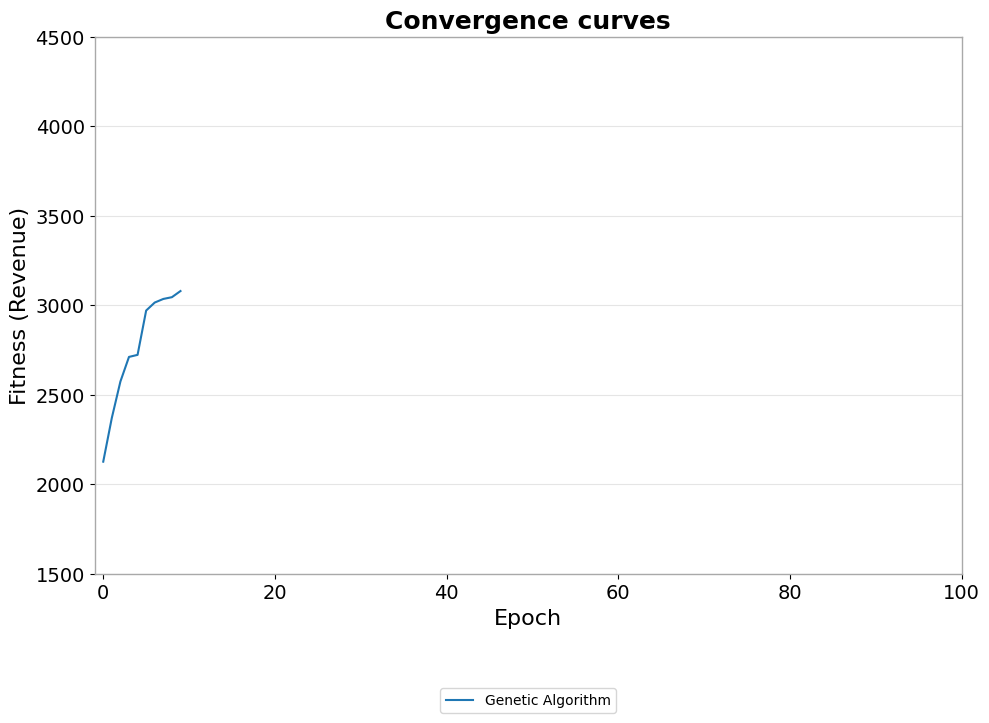

In [29]:
sns_line_plot(df=df_history,
              x_data="Iteration",
              y_data="Fitness",
              hue="Algo",
              title="Convergence curves",
              x_label="Epoch",
              y_label="Fitness (Revenue)",
              x_limit=(-1, 100),
              y_limit=(1500,4500),
              save_path=Path('../reports/mealpy/mealpy_convergence_equity.pdf'),
              fig_size=(10, 9))

In [84]:
df_history.head()

,Run,Algo,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration
0,1,Genetic Algorithm,0,2459.878405,0.246457,"[False, True, False, True, True, True, True, F...","[1070, 1114, 1143, 867, 970, 1046, 902, 827, 9...",3.209825,0.000000,100.000000
1,1,Genetic Algorithm,1,2460.308339,0.243454,"[False, True, False, True, True, True, True, F...","[1061, 1109, 1142, 864, 970, 1045, 898, 822, 9...",2.827368,11.915173,88.084827
2,1,Genetic Algorithm,2,2574.487027,0.243266,"[False, True, False, True, True, True, True, F...","[1061, 1109, 1142, 872, 970, 1045, 902, 822, 9...",2.692281,16.123743,83.876257
3,1,Genetic Algorithm,3,2926.528932,0.239713,"[False, True, False, True, True, True, True, F...","[1061, 1109, 1143, 872, 970, 1045, 902, 822, 9...",2.463509,23.250984,76.749016
4,1,Genetic Algorithm,4,3015.854710,0.239389,"[False, True, False, True, True, False, True, ...","[1061, 1109, 1144, 866, 971, 1046, 904, 827, 9...",2.223509,30.728028,69.271972


In [102]:
N = 50  # Número de saltos que quieres aplicar

algo_1_vals = df_history[df_history['Algo'] == 'Simulated Annealing'] \
    .groupby(['Run', 'Iteration'])['Fitness'].last() \
    .groupby(level='Run').apply(lambda x: x.iloc[::N].tolist()).sum()

algo_1_vals

[1741.0809259234882,
 1748.684776735114,
 1776.928458652797,
 1787.0886195088412,
 1789.277000079085,
 1810.0148541336189,
 1819.9926110593465,
 1821.784191284223,
 1959.0674056539915,
 1965.464324500664,
 1974.408813245351,
 1974.408813245351,
 1993.9478517839375,
 1995.1817405334048,
 1995.1817405334048,
 2199.511541491974,
 2203.9916559426238,
 2203.991655942644,
 2210.439801087261,
 2218.9944671113813,
 2218.9944671113813,
 2218.9944671113813,
 2218.9944671113813,
 2221.9108097656595,
 2225.2391621379447,
 2229.040605359691,
 2241.1760454529403,
 2248.2693960385377,
 2526.072256796473,
 2526.2577480508426,
 2526.257748050876,
 2533.5882980193096,
 2533.5882980193096,
 2534.321215424944,
 2536.263289652836,
 2536.9962070584693,
 2536.9962070584693,
 2538.275235491649,
 2558.405138870365,
 2558.405138870365,
 2558.405138870365,
 2558.405138870365,
 2560.428120624755,
 2560.428120624755,
 2564.110568615207,
 2569.815642866672,
 2573.933454008949,
 2575.597474624795,
 2575.597474624795

In [20]:
algo_df = df_history[df_history['Algo'] == 'Genetic Algorithm']

algo_vals = algo_df.groupby(['Iteration'])['Fitness'].max().tolist()

algo_vals

[2607.780704168451,
 2703.21640230218,
 2911.444314465418,
 3103.973183542429,
 3220.667590931876,
 3365.2866137766955,
 3484.48609472132,
 3572.9260730745227,
 3640.073782168727,
 3669.5832622522,
 3705.136185446733,
 3794.5588181089274,
 3839.792800278671,
 3863.719004722367,
 3906.153305799562,
 3960.321202641717,
 3960.321202641717,
 4005.737551227856,
 4021.701509559909,
 4036.1238629427503,
 4036.374965155991,
 4037.255279037032,
 4047.601165890613,
 4072.3073805030704,
 4100.486496755227,
 4102.769254199621,
 4125.723121565449,
 4149.827532752619,
 4172.08849602329,
 4172.08849602329,
 4183.598501918915,
 4194.791579881078,
 4197.818016088964,
 4226.226027636936,
 4226.226027636936,
 4226.226027636936,
 4228.039611525929,
 4228.705076393186,
 4240.677771701874,
 4240.677771701874,
 4253.38097286305,
 4253.38097286305,
 4253.38097286305,
 4256.742944859372,
 4261.969159858364,
 4309.924958575424,
 4310.657875981058,
 4323.559176282795,
 4323.559176282795,
 4323.559176282795,
 432

In [21]:
print(len(algo_vals))

100


In [26]:
algo_df = df_history[df_history['Algo'] == 'Simulated Annealing']

N = 50
algo_vals = algo_df.groupby(algo_df['Iteration'] // N)['Fitness'].max().tolist()

algo_vals

[2121.942526311217,
 2126.1450191909216,
 2153.200797898652,
 2172.1936191864675,
 2174.216600940857,
 2195.3208372725726,
 2204.6153864302687,
 2223.3679354022047,
 2225.390917156595,
 2244.3606160414943,
 2244.3606160414943,
 2247.4535123926985,
 2270.379052946466,
 2270.492084344696,
 2274.816620508482,
 2298.572311796074,
 2316.002237825652,
 2316.002237825652,
 2316.002237825652,
 2320.215221955512,
 2325.565748811522,
 2332.3340863078133,
 2339.717662177076,
 2345.9459463700828,
 2349.005632648977,
 2583.144820693363,
 2590.85225513937,
 2592.3896854296745,
 2596.703525330692,
 2596.703525330692,
 2599.58923714303,
 2623.8452559548505,
 2623.8452559548505,
 2628.9170645467857,
 2630.988554963445,
 2635.5254248523797,
 2649.8720529088614,
 2655.7557863545885,
 2659.9093170072138,
 2660.827594946524,
 2668.118106647075,
 2668.118106647075,
 2671.661031899009,
 2673.3758957005743,
 2673.3758957005743,
 2673.3758957005743,
 2673.3758957005743,
 2673.3758957005743,
 2673.3758957005743

In [27]:
print(len(algo_vals))

100


In [28]:
# Confusion Matrix stadistical differences 

from scipy import stats

def get_epoch_last_fitness(df, name):
    algo_df = df[df['Algo'] == name]
    if name != 'Simulated Annealing':
        algo_vals = algo_df.groupby(['Run', 'Iteration'])['Fitness'].last().groupby(level='Run').apply(list).sum()
    else:
        algo_vals = algo_df.groupby(['Run', 'Iteration'])['Fitness'].last().groupby(level='Run').apply(lambda x: x.iloc[::N].tolist()).sum()
    return algo_vals

def get_epoch_best_fitness(df, name):
    algo_df = df[df['Algo'] == name]
    if name != 'Simulated Annealing':
        algo_vals = algo_df.groupby(['Iteration'])['Fitness'].max().tolist()
    else:
        algo_vals = algo_df.groupby(algo_df['Iteration'] // N)['Fitness'].max().tolist()
    return algo_vals

matrix_wilcoxon = []
matrix_p_values = []
for algo_name, algo in mp_algos.items():
    row_w = []
    row_p = []
    for algo_name_2, algo_2 in mp_algos.items():
        if algo_name == algo_name_2:
            row_w.append(np.nan)
            row_p.append(np.nan)
            continue
        
        algo_1_vals = get_epoch_best_fitness(df_history, algo_name)
        algo_2_vals = get_epoch_best_fitness(df_history, algo_name_2)
        stat, p_value = stats.wilcoxon(algo_1_vals, algo_2_vals)
        row_w.append(round(stat))
        row_p.append(round(p_value, 3))
    matrix_wilcoxon.append(row_w)
    matrix_p_values.append(row_p)

In [29]:
print("Wilcoxon Matrix")
df_wilcoxon = pd.DataFrame(matrix_wilcoxon, index=mp_algos.keys(), columns=mp_algos.keys())
print(df_wilcoxon)

Wilcoxon Matrix
                                                 Genetic Algorithm  \
Genetic Algorithm                                              NaN   
Particle Swarm Optimization                                    0.0   
Simulated Annealing                                            0.0   
Differential Evolution                                         0.0   
Ant Colony Optimization Continuous (ACOR)                      3.0   
Covariance Matrix Adaptation Evolution Strategy               39.0   
Artificial Bee Colony                                          1.0   
Grey Wolf Optimizer                                            0.0   
Whale Optimization Algorithm                                 239.0   
Hybrid Grey Wolf - Whale Optimization Algorithm                0.0   

                                                 Particle Swarm Optimization  \
Genetic Algorithm                                                        0.0   
Particle Swarm Optimization                          

In [30]:
print("P-Values Matrix")
df_p_values = pd.DataFrame(matrix_p_values, index=mp_algos.keys(), columns=mp_algos.keys())
print(df_p_values)

P-Values Matrix
                                                 Genetic Algorithm  \
Genetic Algorithm                                              NaN   
Particle Swarm Optimization                                    0.0   
Simulated Annealing                                            0.0   
Differential Evolution                                         0.0   
Ant Colony Optimization Continuous (ACOR)                      0.0   
Covariance Matrix Adaptation Evolution Strategy                0.0   
Artificial Bee Colony                                          0.0   
Grey Wolf Optimizer                                            0.0   
Whale Optimization Algorithm                                   0.0   
Hybrid Grey Wolf - Whale Optimization Algorithm                0.0   

                                                 Particle Swarm Optimization  \
Genetic Algorithm                                                      0.000   
Particle Swarm Optimization                          

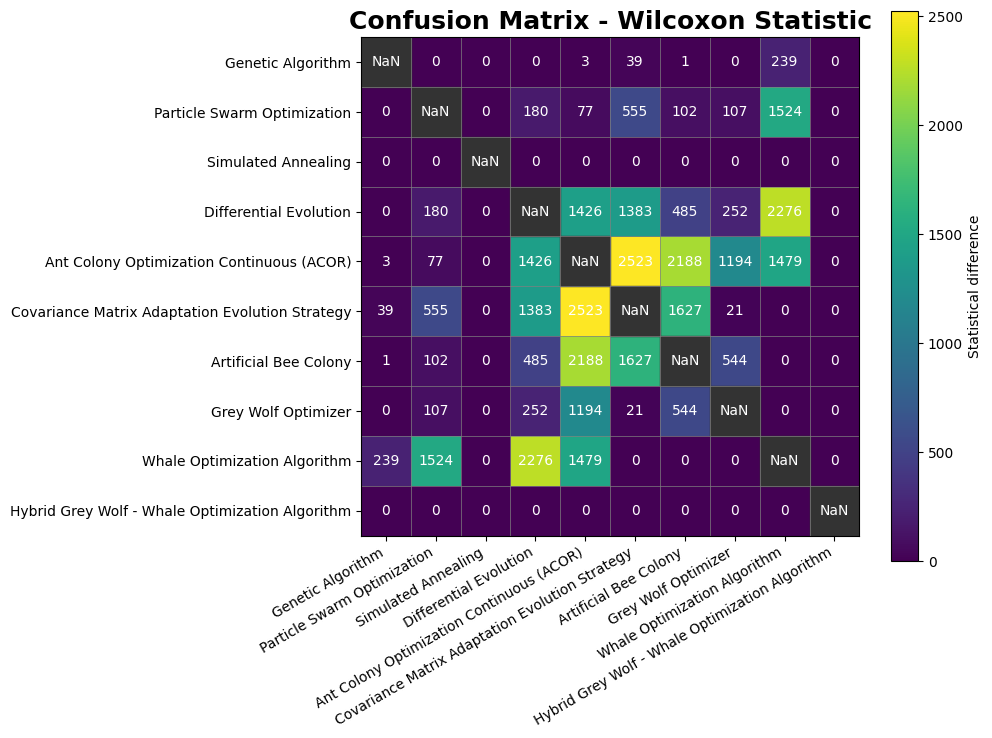

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(df_wilcoxon, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Statistical difference')
plt.xticks(range(10), df_wilcoxon.columns, rotation=30, ha='right')
plt.yticks(range(10), df_wilcoxon.index)
plt.title('Confusion Matrix - Wilcoxon Statistic', fontweight='bold', fontsize=18)

for i in range(df_wilcoxon.shape[0]):
    for j in range(df_wilcoxon.shape[1]):
        value = df_wilcoxon.iloc[i, j]
        if np.isnan(value):
            # Manejo especial para NaN
            display_value = "NaN"
            text_color = 'white'  # Color negro para NaN
            rect_color = (0.2, 0.2, 0.2)  # Gris oscuro
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{int(value)}"
            text_color = 'black' if value > 50000 else 'white'
        
        plt.text(j, i, display_value, ha='center', va='center', color=text_color)
        
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/wilcoxon_confusion_matrix_5_seed.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

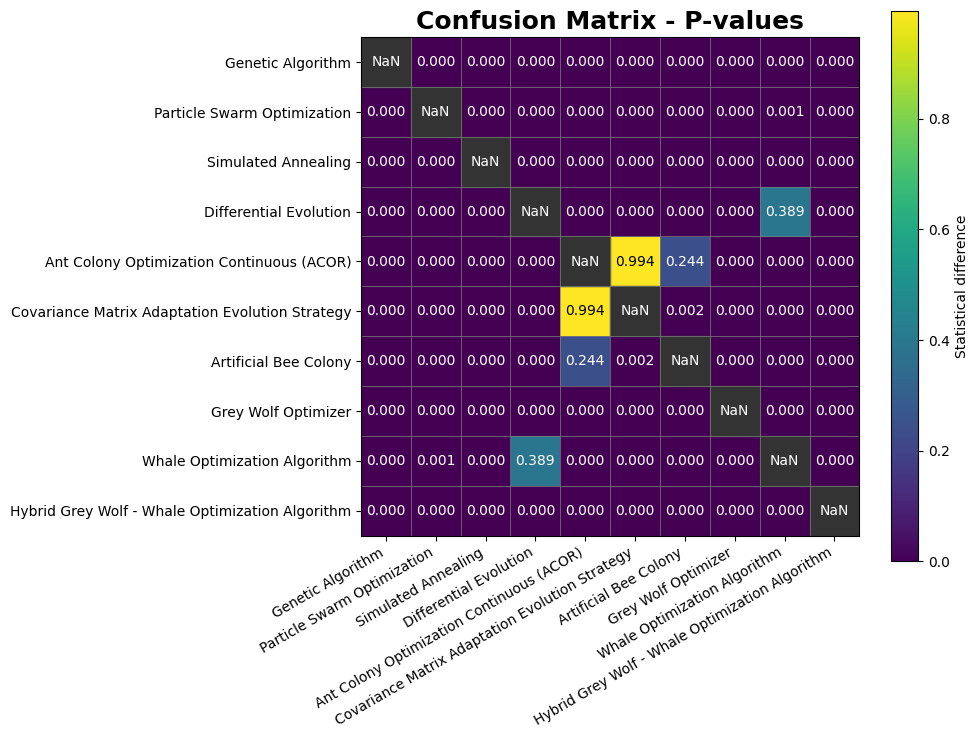

In [33]:
# Visualización con matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(df_p_values, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Statistical difference')
plt.xticks(range(10), df_p_values.columns, rotation=30, ha='right')
plt.yticks(range(10), df_p_values.index)
plt.title('Confusion Matrix - P-values', fontweight='bold', fontsize=18)

for i in range(df_p_values.shape[0]):
    for j in range(df_p_values.shape[1]):
        value = df_p_values.iloc[i, j]
        if np.isnan(value):
            # Manejo especial para NaN
            display_value = "NaN"
            text_color = 'white'  # Color negro para NaN
            rect_color = (0.2, 0.2, 0.2)  # Gris oscuro
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{value:.3f}"
            text_color = 'black' if value > 0.4 else 'white'
        
        plt.text(j, i, display_value, ha='center', va='center', color=text_color)
        
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/p_values_confusion_matrix_5_seed.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

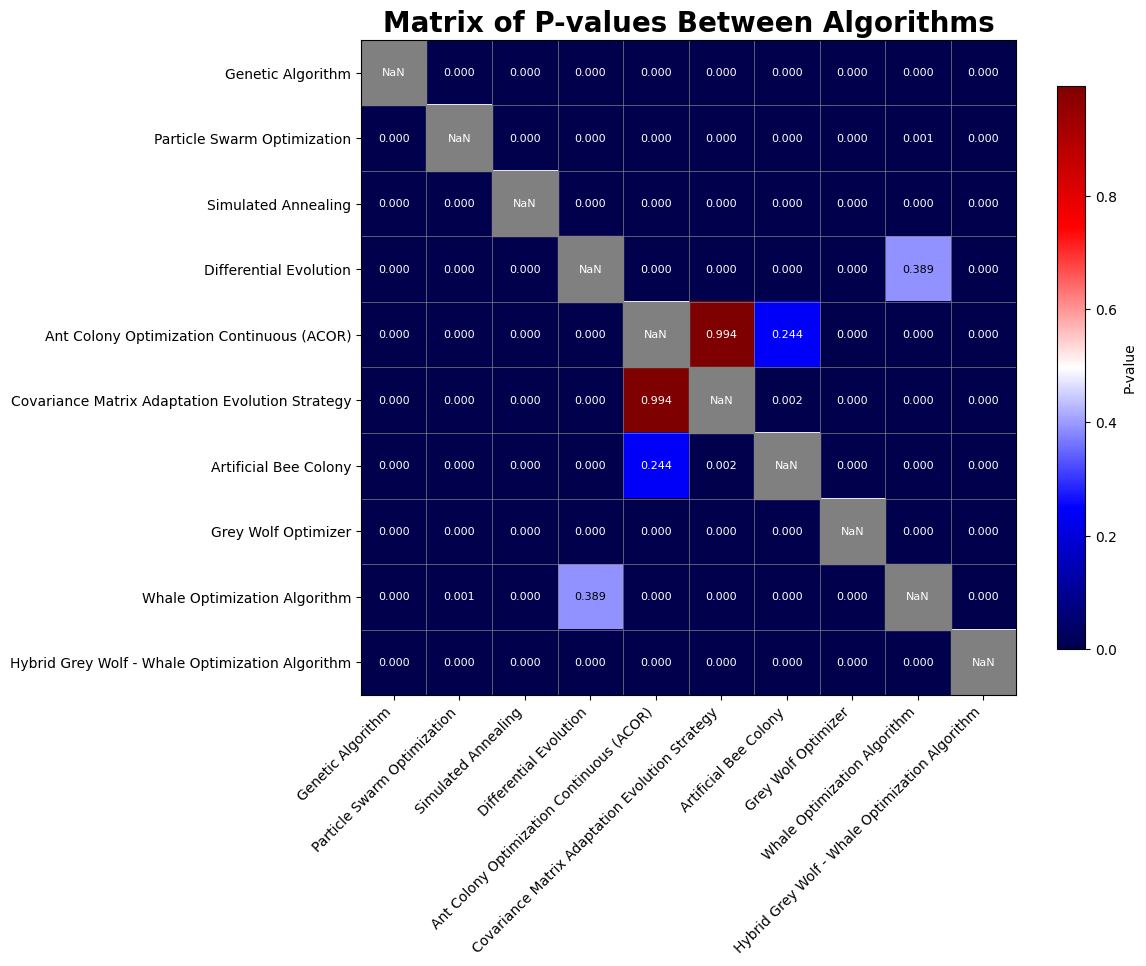

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(12, 10))
plt.imshow(df_p_values, cmap='seismic', interpolation='nearest')
plt.colorbar(label='P-value', shrink=0.8)
plt.xticks(range(df_p_values.shape[1]), df_p_values.columns, rotation=45, ha='right', fontsize=10)
plt.yticks(range(df_p_values.shape[0]), df_p_values.index, fontsize=10)
plt.title('Matrix of P-values Between Algorithms', fontweight='bold', fontsize=20)

for i in range(df_p_values.shape[0]):
    for j in range(df_p_values.shape[1]):
        value = df_p_values.iloc[i, j]
        if np.isnan(value):
            display_value = "NaN"
            text_color = 'white'
            rect_color = (0.5, 0.5, 0.5)
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{value:.3f}"
            text_color = 'black' if value > 0.3 and value < 0.7 else 'white'
        
        plt.text(j, i, display_value, ha='center', va='center', color=text_color, fontsize=8)

ax = plt.gca()
ax.set_xticks(np.arange(-0.5, df_p_values.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, df_p_values.shape[0], 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/p_values_confusion_matrix_improved.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [36]:
stat, p_value = stats.wilcoxon(genetic_revenues_mean, acor_revenues_mean)
print(f"Estadístico de Wilcoxon: {stat}, Valor p: {p_value}")

Estadístico de Wilcoxon: 0.0, Valor p: 0.0625


In [31]:
# Select a solution from df_history:
algo_name = 'Genetic Algorithm'
run = 1
iteration = 9

filtered_row = df_history[
    (df_history["Algo"] == algo_name) &
    (df_history["Run"] == run) &
    (df_history["Iteration"] == iteration)
]

# Get values from columns "Real" & "Discrete"
if not filtered_row.empty:
    real_value = filtered_row["Real"].iloc[0]
    discrete_value = filtered_row["Discrete"].iloc[0]
    ga_best_sol = Solution(real=real_value, discrete=discrete_value)
    print(f"Real: {real_value}, Discrete: {discrete_value}")
else:
    print("Row not found matching the provided parameters.")

Real: [1053 1108 1146  862  971 1051  898  824  913 1349  728  123  210  277
  489  528  639  694  929  744  190  389  459  515  938  970 1040 1104
 1142 1163 1195 1263 1315 1350  404  471  509  269  328  370  521  579
 1069 1188 1250 1295  554  613  650 1243  464  528  570 1280  900 1004
 1068], Discrete: [ True False  True  True  True  True  True False False  True  True False
 False False  True  True  True False  True  True  True  True  True  True
 False]


In [33]:
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)

services = sm.update_supply(path=generator_save_path,
                            solution=ga_best_sol)

sm.update_schedule(solution=ga_best_sol)

filtered_services = {}
for i, service in enumerate(sm.updated_schedule):
    if ga_best_sol.discrete[i]:
        filtered_services[service] = sm.updated_schedule[service]

#plotter = TrainSchedulePlotter(filtered_services, line)
#plotter.plot(plot_security_gaps=True, save_path=Path('../figures/updated.pdf'))

tt_file_name = f'{supply_config_path.stem}_gsa'
print(supply_save_path, tt_file_name)
SupplySaver(services).to_yaml(filename=f'{tt_file_name}.yml', save_path=supply_save_path)

# Copy previous file in reports
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'{tt_file_name}_25_new.yml')

supply_config_file = Path(f'{supply_save_path}{tt_file_name}.yml')

../configs/mealpy/ supply_config_gsa


In [34]:
final_supply = Supply.from_yaml(supply_config_file)

/Users/david/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


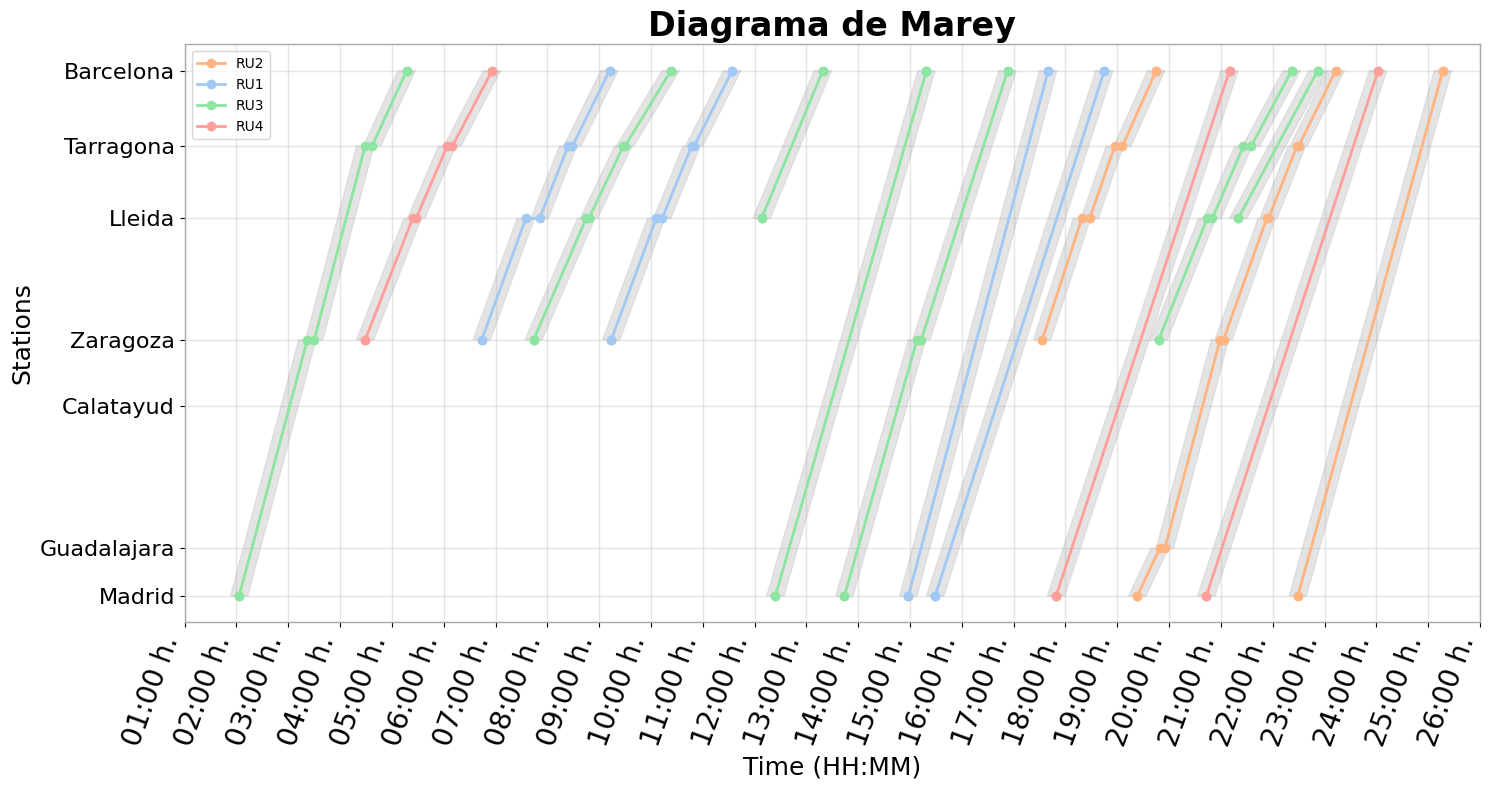

In [35]:
plot_marey_chart(requested_supply=final_supply,
                 colors_by_tsp=True, 
                 main_title="Diagrama de Marey",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/mealpy/marey_chart_ga_25.pdf'))

In [38]:
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'mealpy/{tt_file_name}_25.yml')

PosixPath('../reports/mealpy/supply_config_gsa_25.yml')

In [30]:
#!snakeviz profile.pstat